# Building the simplest Graph

We start with a graph with two nodes connected by one edge.


In [ ]:
pip install langgraph langchain_community langchain langchain_openai langchain_experimental python-dotenv pyowm setuptools httpx==0.27.2

Nodes act like functions that can be called as needed. In our case Node 1 is our starting point and Node 2 is our finish point.

In [1]:
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

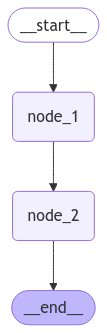

In [2]:
from langgraph.graph import Graph
from IPython.display import Image, display

# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()


display(Image(app.get_graph().draw_mermaid_png()))


In [3]:
app.invoke("Hello")

'Hello Hi there'

In [4]:
input = 'Hello'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Hello Hi 

---

Output from node 'node_2':
---
Hello Hi there

---



### As you can see, we can run the nodes as functions and return some values from them.



# Adding LLM Call

Now, let's make the first node as an "Agent" that can call Open AI models. We can use langchain to make this call easy for us.

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

A usual call to ChatOpenAI model in LangChain is done as below:

First set your API keys for OpenAI

In [6]:
from langchain_openai import ChatOpenAI

# Set the model as ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")

#Call the model with a user message
model.invoke('Hey there')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-f9ceb323-fb54-4b9f-a4ca-55dbf9fc129b-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

And if you just want to see the AI response, you can do the following:

In [7]:
model.invoke('Hey there').content

'Hello! How can I assist you today?'

Cool! Keeping that in mind, let's change the function 1 above so that we can send the user question to the model. Then we will send this response to function 2, which will add a short string and return to the user.

In [8]:
def function_1(input_1):
    response = model.invoke(input_1)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

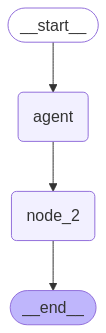

In [9]:
from IPython.display import Image, display

# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))


In [10]:
app.invoke("Hey there")

'Agent Says: Hello! How can I assist you today?'

In [11]:
input = 'Hey there'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Hello! How can I help you today?

---

Output from node 'node_2':
---
Agent Says: Hello! How can I help you today?

---



# First functional Agent App - City Temperature

### Step 1: Parse the city mentioned
Let's extract the city that a user mentions in a query

In [12]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    return "Agent Says: " + input_2

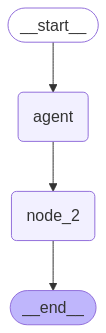

In [13]:
from IPython.display import Image, display

# Define a Langchain graph
workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('agent', 'node_2')

workflow.set_entry_point("agent")
workflow.set_finish_point("node_2")

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))


In [14]:
app.invoke("What's the temperature in Las Vegas")

'Agent Says: Las Vegas'

### Step 2: Adding a weather API call

What if we want the function 2 to take the city name and give us the weather for that city.

Well we know that Open Weather Map is [integrated](https://python.langchain.com/docs/integrations/tools/openweathermap) into LangChain

We need to install pyown, create an API key on the website of Open Weather Map (which takes a few hours to activate) and then run the cells below to get weather of a given city.

In [15]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
import os
os.environ["OPENWEATHERMAP_API_KEY"] = "cba894c60724a02c986ab11fbc25da09"
print(os.environ["OPENWEATHERMAP_API_KEY"])
weather = OpenWeatherMapAPIWrapper()


cba894c60724a02c986ab11fbc25da09


In [16]:
weather_data = weather.run("Bangalore")
print(weather_data)

In Bangalore, the current weather is as follows:
Detailed status: clear sky
Wind speed: 3.09 m/s, direction: 120°
Humidity: 68%
Temperature: 
  - Current: 25.19°C
  - High: 25.9°C
  - Low: 24.8°C
  - Feels like: 25.54°C
Rain: {}
Heat index: None
Cloud cover: 1%


Now, let's integrate this into function 2 and call the function two as a "tool" or "weather_agent" instead of "node_2" in our workflow.

In [17]:
def function_1(input_1):
    complete_query = "Your task is to provide only the city name based on the user query. \
        Nothing more, just the city name mentioned. Following is the user query: " + input_1
    response = model.invoke(complete_query)
    return response.content

def function_2(input_2):
    weather_data = weather.run(input_2)
    return weather_data

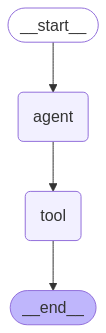

In [18]:
from langgraph.graph import Graph

workflow = Graph()

#calling node 1 as agent
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('agent', 'tool')

workflow.set_entry_point("agent")
workflow.set_finish_point("tool")

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
app.invoke("What's the temperature in Hyderabad")

'In Hyderabad, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 3.6 m/s, direction: 100°\nHumidity: 42%\nTemperature: \n  - Current: 29.23°C\n  - High: 29.23°C\n  - Low: 26.73°C\n  - Feels like: 29.04°C\nRain: {}\nHeat index: None\nCloud cover: 0%'

In [20]:
input = "What's the temperature in Bangalore"
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
Bangalore

---

Output from node 'tool':
---
In Bangalore, the current weather is as follows:
Detailed status: clear sky
Wind speed: 3.09 m/s, direction: 120°
Humidity: 68%
Temperature: 
  - Current: 25.19°C
  - High: 25.9°C
  - Low: 24.8°C
  - Feels like: 25.54°C
Rain: {}
Heat index: None
Cloud cover: 1%

---



### Step 3 Adding another LLM Call to filter results

What if we only want the temperature? But current setup gives us the full weather report.

Well we can make another LLM call to filter data

In [21]:
def function_3(input_3):
    complete_query = """Your task is to provide info concisely based on the
     user query. Following is the user query: """ + input_3
    response = model.invoke(complete_query)
    return response.content

But the issue is the user input is not available from node 2.

Can we pass user input all along from first node to the last?

Yes, we can use a dictionary and pass it between nodes (we could also use just a list, but dict makes it a bit easier)

In [22]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array.
# We will append new messages as we pass along nodes.
AgentState["messages"] = []

In [23]:
AgentState

{'messages': []}

Our goal is to have this state filled as:
{'messages': [HumanMessage, AIMessage, ...]]}

Also now we need to modify our functions to pass info along the new AgentState

In [24]:
def function_1(state):
    messages = state['messages']
    user_input = messages[-1]
    complete_query = "Your task is to provide only the city name based on the user query. \
                    Nothing more, just the city name mentioned. Following is the user query: " + user_input
    response = model.invoke(complete_query)
    state['messages'].append(response.content) # appending AIMessage response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    agent_response = messages[-1]
    weather = OpenWeatherMapAPIWrapper()
    weather_data = weather.run(agent_response)
    state['messages'].append(weather_data)
    return state

def function_3(state):
    messages = state['messages']
    user_input = messages[0]
    available_info = messages[-1]
    agent2_query = """Your task is to provide info concisely based on the
             user query and the available information from the internet.
            Following is the user query: """ + user_input + " Available information: " + available_info
    response = model.invoke(agent2_query)
    return response.content


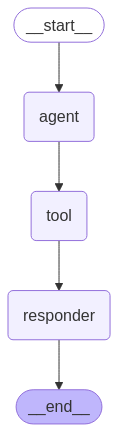

In [25]:
from langgraph.graph import Graph

workflow = Graph()


workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)
workflow.add_node("responder", function_3)

workflow.add_edge('agent', 'tool')
workflow.add_edge('tool', 'responder')

workflow.set_entry_point("agent")
workflow.set_finish_point("responder")

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
inputs = {"messages": ["what is the temperature in Bangalore"]}
app.invoke(inputs)

'The current temperature in Bangalore is 25.19°C, with a high of 25.9°C and a low of 24.8°C. It feels like 25.54°C.'

In [27]:
input = {"messages": ["what is the humidity in Bangalore"]}
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': ['what is the humidity in Bangalore', 'Bangalore']}

---

Output from node 'tool':
---
{'messages': ['what is the humidity in Bangalore', 'Bangalore', 'In Bangalore, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 3.09 m/s, direction: 120°\nHumidity: 68%\nTemperature: \n  - Current: 25.19°C\n  - High: 25.9°C\n  - Low: 24.8°C\n  - Feels like: 25.54°C\nRain: {}\nHeat index: None\nCloud cover: 1%']}

---

Output from node 'responder':
---
The current humidity in Bangalore is 68%.

---



As we notice that there is a lot of appending to the array going on, we can make it a bit easier with the following:

```bash
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[list, operator.add]


Let's start with the AgentState definition as mentioned above

In [28]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
     # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
   # messages: Annotated[Sequence[BaseMessage], operator.add]

**Understanding about add_messages**

In [29]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1ace19ce-05fe-428b-99bd-e451e4d6eec5'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='af779fb2-9a06-460f-a100-03a7174c8344'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='570b0bd2-c46d-47a9-9760-87ffdcecc1f7')]

**Re-writing**

If we pass a message with the same ID as an existing one in our messages list, it will get overwritten!

In [30]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

**Removal**

add_messages also enables message removal.

For this, we simply use RemoveMessage from langchain_core.

In [31]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [32]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

It basically makes the state dictionary as seen previously, and also makes sure that any new message is appended to the messages array when we return  the following in our function:
```bash
{"messages": [new_array_element]}
```


##### We also realize that our app is not capable of answering simple questions like "how are you?"

In [33]:
inputs = {"messages": ["how are you?"]}
app.invoke(inputs)

APIRequestError: {"cod":"400","message":"Nothing to geocode"}

This is because we always want to parse a city and then find the weather.

We can make our agent smarter by saying only use the tool when needed, if not just respond back to the user.

The way we can do this LangGraph is:
1. binding a tool to the agent
2. adding a conditional edge to the agent with the option to either call the tool or not
3. defining the criteria for the conditional edge as when to call the tool. We will define a function for this.




Binding tool with agent (LLM Model) is made easy in langchain

In [34]:
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [OpenWeatherMapQueryRun(),add, multiply, divide]



model = ChatOpenAI(temperature=0, streaming=True)
model=model.bind_tools(tools)
#functions = [convert_to_openai_function(t) for t in tools]
#model = model.bind_functions(functions)

Our modified function_1 now becomes as below. The reason is, we are passing the human message as state and appending response to the state. Also, our agent now has a tool bound to it, that it can use.

In [35]:
def function_1(state):
    messages = state['messages']

    response = model.invoke(messages)
    print("Response from function_1",response)
    return {"messages": [response]}

For function 2,We can use ToolNode cirectly provided by langchain. In earlier version of lang graph, we need to define a function which uses ToolExecutor. But it id deprecated now

Finally, we define a function for the conditional edge, to help us figure out which direction to go (tool or user response)

We can benefit from the agent (LLM) response in LangChain, which has additional_kwargs to make a function_call with the name of the tool.

So our logic is, if function_call available in the additional_kwargs, then call tool if not then end the discussion and respond back to the user

In [36]:
def where_to_go(state):
    messages = state['messages']
    last_message = messages[-1]
    print("Inside where to go=== ",last_message)

    if "tool_calls" in last_message.additional_kwargs:
        return "continue"
    else:
        return "end"

In [ ]:
pip install langgraph-checkpoint-sqlite

Now with all of the changes above, our LangGraph app is modified as below:

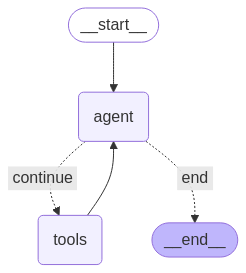

In [37]:
from langgraph.pregel import RetryPolicy
from langgraph.checkpoint.memory import MemorySaver
import sqlite3


# from langgraph.graph import Graph, END

# workflow = Graph()

# Or you could import StateGraph and pass AgentState to it
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode,tools_condition
#workflow = StateGraph(AgentState)

#workflow = StateGraph(state_schema=AgentState,input=AgentState,output=AgentState )

workflow = StateGraph(state_schema=AgentState )



workflow.add_node("agent", function_1)

workflow.add_node("tools",ToolNode(tools=tools),retry=RetryPolicy(max_attempts=5))


# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_conditional_edges("agent", where_to_go,{   # Based on the return from where_to_go
                                                        # If return is "continue" then we call the tool node.
                                                        "continue": "tools",
                                                        # Otherwise we finish.
                                                        "end": END
                                                    }
)



#workflow.add_conditional_edges("agent", tools_condition)

# We now add a normal edge from `tools` to `agent`.
# This means that if `tools` is called, then it has to call the 'agent' next.
workflow.add_edge('tools', 'agent')

# Basically, agent node has the option to call a tool node based on a condition,
# whereas tool node must call the agent in all cases based on this setup.

workflow.set_entry_point("agent")

#from langgraph.checkpoint.sqlite import SqliteSaver


memory = MemorySaver()



#conn = sqlite3.connect(":memory:", check_same_thread = False)
#conn = sqlite3.connect("checkpoints.sqlite",check_same_thread=False)
#memory = SqliteSaver.from_conn_string("checkpoints.sqlite")
#memory = SqliteSaver(conn)
#checkpointer.setup()

#from langgraph.checkpoint.sqlite import SqliteSaver
#memory = SqliteSaver(conn)

app = workflow.compile(
     checkpointer=memory
     #interrupt_before=["tool"]
)

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

#app.get_graph().draw_mermaid_png(output_file_path="graph.png")

We also pass the first message using HumanMessage component available in langchain, makes it easy to differentiate from AIMessage, and FunctionMessage

In [38]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="what is the humidity in Chennai")]}
response = app.invoke(inputs,config)
response

Response from function_1 content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'function': {'arguments': '{"location":"Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'} id='run-6b23fe25-1bee-42f4-8f9e-de40be7088ff-0' tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'Chennai'}, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'type': 'tool_call'}]
Inside where to go===  content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'function': {'arguments': '{"location":"Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'} id='run-6b23fe25-1bee-42f4-8f9e-de40be7088ff-0' tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'Chennai'}, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'type': 'tool_call'}]
Response from 

{'messages': [HumanMessage(content='what is the humidity in Chennai', additional_kwargs={}, response_metadata={}, id='54ba713b-87b4-4da5-b7f3-2657784511d2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'function': {'arguments': '{"location":"Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-6b23fe25-1bee-42f4-8f9e-de40be7088ff-0', tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'Chennai'}, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'type': 'tool_call'}]),
  ToolMessage(content='In Chennai, the current weather is as follows:\nDetailed status: scattered clouds\nWind speed: 3.09 m/s, direction: 190°\nHumidity: 83%\nTemperature: \n  - Current: 28.82°C\n  - High: 28.99°C\n  - Low: 28.33°C\n  - Feels like: 34.88°C\nRain: {}\nHeat index: None\nCloud cover: 40%', name='open_weather_map', id='f1bbdcec-ea0c-4cdb-9

In [40]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [HumanMessage(content="what is my eariler query exactly?")]}
response = app.invoke(inputs,config)

for output in app.stream(inputs,config):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Response from function_1 content='Your earlier query was about the humidity in Chennai.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'} id='run-62c61534-b5ff-4d53-b56e-ee9f8565750e-0'
Inside where to go===  content='Your earlier query was about the humidity in Chennai.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'} id='run-62c61534-b5ff-4d53-b56e-ee9f8565750e-0'
Response from function_1 content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_vcf4S8JPDGAcXNv5uHUgJcl8', 'function': {'arguments': '{"location": "Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}, {'index': 1, 'id': 'call_9xBi5IWOAxATUxVmkoqykknq', 'function': {'arguments': '{"location": "Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'} id='run-84dcb75c-7d25-44e4-bc49-b6d97639d4c7-0' tool_calls=

In [41]:
snapshot = app.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='what is the humidity in Chennai', additional_kwargs={}, response_metadata={}, id='54ba713b-87b4-4da5-b7f3-2657784511d2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'function': {'arguments': '{"location":"Chennai"}', 'name': 'open_weather_map'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-6b23fe25-1bee-42f4-8f9e-de40be7088ff-0', tool_calls=[{'name': 'open_weather_map', 'args': {'location': 'Chennai'}, 'id': 'call_K49LpN3OQnSOTIEb9YH60U9p', 'type': 'tool_call'}]), ToolMessage(content='In Chennai, the current weather is as follows:\nDetailed status: scattered clouds\nWind speed: 3.09 m/s, direction: 190°\nHumidity: 83%\nTemperature: \n  - Current: 28.82°C\n  - High: 28.99°C\n  - Low: 28.33°C\n  - Feels like: 34.88°C\nRain: {}\nHeat index: None\nCloud cover: 40%', name='open_weather_map', id='f1b

In [ ]:
user_input = "What is java language? "
config = {"configurable": {"thread_id": "15"}}
# The config is the **second positional argument** to stream() or invoke()!
events = app.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
user_input = "What is 2+5 multiplied by 7? "
config = {"configurable": {"thread_id": "15"}}
# The config is the **second positional argument** to stream() or invoke()!
events = app.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = app.get_state(config)
snapshot

## Multiple Schemas

We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

## Private State

First, let's cover the case of passing private state between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an OverallState and a PrivateState.

node_2 uses PrivateState as input, but writes out to OverallState.

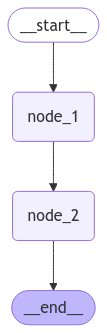

In [42]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

baz is only included in PrivateState.

node_2 uses PrivateState as input, but writes out to OverallState.

So, we can see that baz is excluded from the graph output because it is not in OverallState.

##Input / Output Schema

By default, StateGraph takes in a single schema and all nodes are expected to communicate with that schema.

However, it is also possible to define explicit input and output schemas for a graph.

Often, in these cases, we define an "internal" schema that contains all keys relevant to graph operations.

But, we use specific input and output schemas to constrain the input and output.

First, let's just run the graph with a single schema.

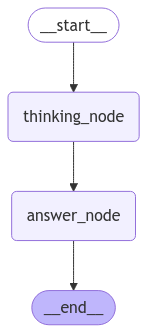

In [44]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his is name is Siva"}

def answer_node(state: OverallState):
    return {"answer": "bye Siva"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke contains all keys in OverallState.

In [45]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Siva', 'notes': '... his is name is Siva'}

Now, let's use a specific input and output schema with our graph.

Here, input / output schemas perform filtering on what keys are permitted on the input and output of the graph.

In addition, we can use a type hint state: InputState to specify the input schema of each of our nodes.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of answer_node will be filtered to OutputState.

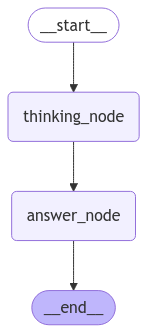

{'answer': 'bye Siva'}

In [46]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is siva"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Siva"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the output schema constrains the output to only the answer key.